In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Any

import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from gratis_precip.features import (
    # Base features
    LengthFeature,
    NPeriodsFeature,
    PeriodsFeature,
    NDiffsFeature,
    NSDiffsFeature,
    ACFFeature,
    PACFFeature,
    EntropyFeature,
    NonlinearityFeature,
    HurstFeature,
    StabilityFeature,
    LumpinessFeature,
    UnitRootFeature,
    HeterogeneityFeature,
    TrendFeature,
    SeasonalStrengthFeature,
    SpikeFeature,
    LinearityFeature,
    CurvatureFeature,
    RemainderACFFeature,
    ARCHACFFeature,
    GARCHACFFeature,
    ARCHR2Feature,
    GARCHR2Feature,
    # Precipitation-specific features
    TotalPrecipitation,
    PrecipitationIntensity,
    DrySpellDuration,
    WetSpellDuration,
    PrecipitationVariability,
    ExtremePrecipitationFrequency,
    MaximumDailyPrecipitation,
    WetDayFrequency,
)
from gratis_precip.dimensionality_reduction import (
    DimensionalityReducer,
    TSNEReduction,
    PCAReduction,
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load the precipitation data
df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
precipitation = df["P_mix"].values


In [3]:
def split_into_seasons(
    precipitation: np.ndarray, days_per_season: int = 90
) -> Tuple[List[np.ndarray], List[str]]:
    """
    Split a long precipitation time series into seasonal segments.

    Args:
        precipitation (np.ndarray): The full precipitation time series.
        days_per_season (int): Number of days to consider for each season.

    Returns:
        Tuple[List[np.ndarray], List[str]]: List of seasonal segments and their corresponding season labels.
    """
    segments = []
    labels = []
    seasons = ["Winter", "Spring", "Summer", "Autumn"]

    for i in range(0, len(precipitation) - days_per_season + 1, days_per_season):
        segment = precipitation[i : i + days_per_season]
        segments.append(segment)
        labels.append(seasons[(i // days_per_season) % 4])

    return segments, labels


def classify_seasons(segments: List[np.ndarray], labels: List[str]) -> List[str]:
    """
    Classify seasons as 'Dry' or 'Wet' based on total precipitation.

    Args:
        segments (List[np.ndarray]): List of seasonal precipitation segments.
        labels (List[str]): List of corresponding season labels.

    Returns:
        List[str]: List of classified season labels.
    """
    totals = [np.sum(segment) for segment in segments]
    median = np.median(totals)

    classified_labels = []
    for total, label in zip(totals, labels):
        if total < median:
            classified_labels.append(f"Dry {label}")
        else:
            classified_labels.append(f"Wet {label}")

    return classified_labels

In [4]:
# Split the precipitation data into seasonal segments
segments, season_labels = split_into_seasons(precipitation)

# Classify the seasons
classified_labels = classify_seasons(segments, season_labels)

In [5]:
def flatten(item):
    """Recursively flatten an arbitrarily nested iterable."""
    if isinstance(item, (list, tuple, np.ndarray)):
        return [sub_item for i in item for sub_item in flatten(i)]
    else:
        return [item]


class FeatureExtractor:
    def __init__(self, features: List[Any]):
        self.features = features

    def extract_features(self, time_series: np.ndarray) -> Dict[str, Any]:
        return {
            feature.__class__.__name__: feature.calculate(time_series)
            for feature in self.features
        }

    def extract_feature_matrix(self, time_series_list: List[np.ndarray]) -> np.ndarray:
        all_feature_vectors = []

        for ts in time_series_list:
            features = self.extract_features(ts)
            feature_vector = []
            for value in features.values():
                feature_vector.extend(flatten(value))
            all_feature_vectors.append(feature_vector)

        # Find the maximum length of feature vectors
        max_length = max(len(vector) for vector in all_feature_vectors)

        # Pad shorter vectors with zeros
        uniform_feature_vectors = [
            vector + [0] * (max_length - len(vector)) for vector in all_feature_vectors
        ]

        return np.array(uniform_feature_vectors)

In [6]:
extractor = FeatureExtractor(
    [
        # Base features
        LengthFeature(),
        NPeriodsFeature(),
        PeriodsFeature(),
        NDiffsFeature(),
        NSDiffsFeature(),
        ACFFeature(),
        PACFFeature(),
        EntropyFeature(),
        NonlinearityFeature(),
        HurstFeature(),
        StabilityFeature(),
        LumpinessFeature(),
        UnitRootFeature(),
        HeterogeneityFeature(),
        TrendFeature(),
        SeasonalStrengthFeature(),
        SpikeFeature(),
        LinearityFeature(),
        CurvatureFeature(),
        RemainderACFFeature(),
        ARCHACFFeature(),
        GARCHACFFeature(),
        ARCHR2Feature(),
        GARCHR2Feature(),
        # Precipitation-specific features
        TotalPrecipitation(),
        PrecipitationIntensity(),
        DrySpellDuration(),
        WetSpellDuration(),
        PrecipitationVariability(),
        ExtremePrecipitationFrequency(),
        MaximumDailyPrecipitation(),
        WetDayFrequency(),
    ]
)


In [7]:
# Extract features for all segments
feature_matrix = extractor.extract_feature_matrix(segments)
print(f"Feature matrix shape: {feature_matrix.shape}")

Feature matrix shape: (59, 42)


In [8]:
# Perform dimensionality reduction
reducer = DimensionalityReducer(PCAReduction())
projection = reducer.reduce_dimensions(feature_matrix)

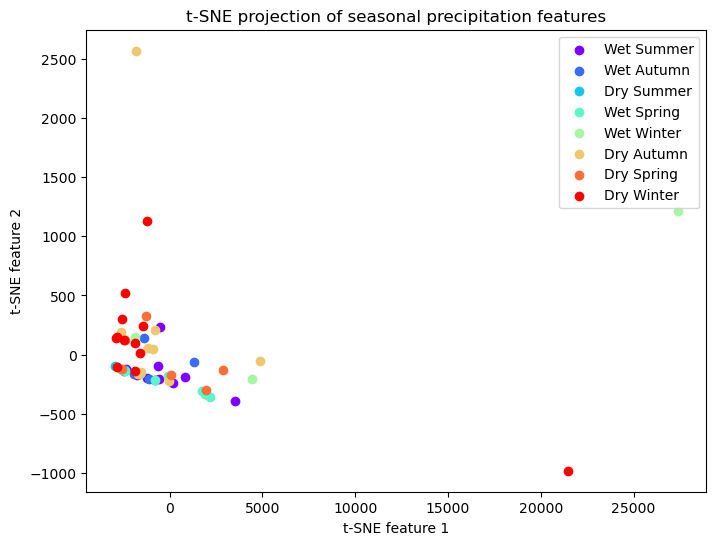

In [9]:
# Visualize the projection
plt.figure(figsize=(8, 6))

unique_labels = list(set(classified_labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(classified_labels) == label
    plt.scatter(projection[mask, 0], projection[mask, 1], label=label, color=color)

plt.title("t-SNE projection of seasonal precipitation features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

In [10]:
# Print some statistics
for season in set(classified_labels):
    season_data = [
        seg for seg, label in zip(segments, classified_labels) if label == season
    ]
    print(f"\n{season} statistics:")
    print(
        f"  Average daily precipitation: {np.mean([np.mean(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Total seasonal precipitation: {np.mean([np.sum(seg) for seg in season_data]):.2f}"
    )
    print(
        f"  Maximum daily precipitation: {np.max([np.max(seg) for seg in season_data]):.2f}"
    )


Wet Summer statistics:
  Average daily precipitation: 4.87
  Total seasonal precipitation: 437.85
  Maximum daily precipitation: 53.80

Wet Autumn statistics:
  Average daily precipitation: 4.50
  Total seasonal precipitation: 405.08
  Maximum daily precipitation: 50.60

Dry Summer statistics:
  Average daily precipitation: 3.54
  Total seasonal precipitation: 318.50
  Maximum daily precipitation: 25.70

Wet Spring statistics:
  Average daily precipitation: 4.82
  Total seasonal precipitation: 433.88
  Maximum daily precipitation: 52.50

Wet Winter statistics:
  Average daily precipitation: 4.28
  Total seasonal precipitation: 384.80
  Maximum daily precipitation: 73.00

Dry Autumn statistics:
  Average daily precipitation: 3.14
  Total seasonal precipitation: 282.18
  Maximum daily precipitation: 57.60

Dry Spring statistics:
  Average daily precipitation: 3.03
  Total seasonal precipitation: 272.27
  Maximum daily precipitation: 50.20

Dry Winter statistics:
  Average daily precipit

In [11]:
from datetime import datetime
from meteostat import Point, Daily

# Define the location (latitude, longitude, and altitude)
location = Point(47.368011576362896, 8.5387625442684280)  # Example: Zurich

# Define the time period
start = datetime(1986, 1, 1)
end = datetime(2023, 12, 31)

# Get daily data
data = Daily(location, start, end)
data = data.fetch()

# Print precipitation data
print(data[['prcp']])

precipitation_meteostat = data['prcp'].values


            prcp
time            
1986-01-01   4.0
1986-01-02   1.7
1986-01-03   4.9
1986-01-04   0.4
1986-01-05   1.2
...          ...
2023-12-27   0.0
2023-12-28   0.4
2023-12-29   0.1
2023-12-30   0.0
2023-12-31   2.4

[13879 rows x 1 columns]


In [12]:
# Split the precipitation_meteostat data into seasonal segments
segments_meteostat, season_labels_meteostat = split_into_seasons(precipitation_meteostat)

# Classify the seasons
classified_labels_meteostat = classify_seasons(segments_meteostat, season_labels_meteostat)

In [13]:
# Extract features for all segments
feature_matrix_meteostat = extractor.extract_feature_matrix(segments_meteostat)
print(f"Feature matrix shape: {feature_matrix_meteostat.shape}")

Feature matrix shape: (154, 42)


In [14]:
# Perform dimensionality reduction
projection_meteostat = reducer.reduce_dimensions(feature_matrix_meteostat)

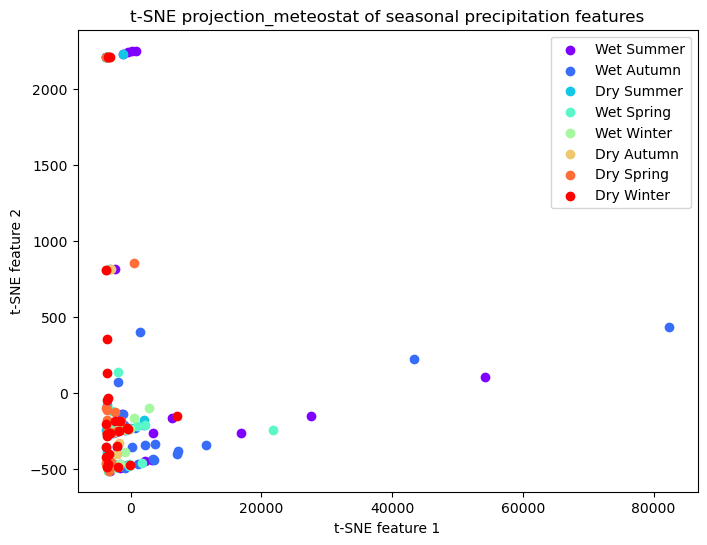

In [15]:
# Visualize the projection_meteostat
plt.figure(figsize=(8, 6))

unique_labels = list(set(classified_labels_meteostat))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(classified_labels_meteostat) == label
    plt.scatter(projection_meteostat[mask, 0], projection_meteostat[mask, 1], label=label, color=color)

plt.title("t-SNE projection_meteostat of seasonal precipitation features")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend()
plt.show()

In [16]:
from gratis_precip.models import ARComponent, CompositeComponent, MARDataGenerator
import matplotlib.pyplot as plt

In [17]:
# Load the precipitation data
df = pd.read_csv("/Users/cooper/Desktop/gratis-precip/data/GSTEIGmeteo copy.csv")
df.index = pd.to_datetime(df["date"])
data = df["P_mix"]

INFO:gratis_precip.models.mar:Preprocessing data...
INFO:gratis_precip.models.mar:Input data range: 0.0 to 73.0
INFO:gratis_precip.models.mar:Input data length: 5387
INFO:gratis_precip.models.mar:After zero handling: 0.1 to 73.0
INFO:gratis_precip.models.mar:After Box-Cox: -0.9483840397897534 to 1.7330879326001436
INFO:gratis_precip.models.mar:Residuals range: -2.026493453380461 to 2.4703280669263923
INFO:gratis_precip.models.mar:Standardized range: -2.59150029229255 to 3.1032128950419597
INFO:gratis_precip.models.mar:Fitted GEV parameters: c=-0.4588, loc=23.3185, scale=4.0428
INFO:gratis_precip.models.mar:Generating 10 trajectories...
INFO:gratis_precip.models.mar:Generating trajectory 1
INFO:gratis_precip.models.mar:Raw trajectory range: -1.4574802271957499 to 0.4077081524056471
INFO:gratis_precip.models.mar:Postprocessing data...
INFO:gratis_precip.models.mar:Input data range: -1.4574802271957499 to 0.4077081524056471
INFO:gratis_precip.models.mar:Unstandardized range: -1.1310162510

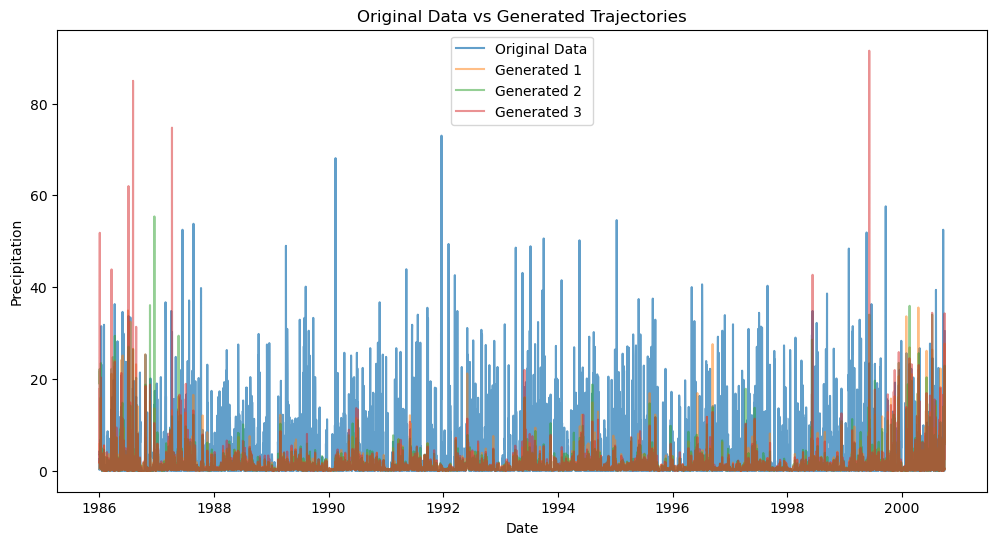

In [18]:
# Create MAR model components
ar1 = ARComponent(order=1, weight=0.3)
ar2 = ARComponent(order=2, weight=0.3)
ar3 = ARComponent(order=3, weight=0.4)

# Create a composite component
composite = CompositeComponent([ar1, ar2, ar3])

# Create the MARDataGenerator
mar_generator = MARDataGenerator(root_component=composite, steps=len(data), seasonal_period=365)

# Fit the model to the data
mar_generator.fit(data)

# Generate new trajectories
generated_trajectories = mar_generator.generate(n_trajectories=10)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Original Data', alpha=0.7)
for i in range(3):  # Plot 3 of the generated trajectories
    plt.plot(generated_trajectories.index, generated_trajectories.iloc[:, i], label=f'Generated {i+1}', alpha=0.5)
plt.legend()
plt.title("Original Data vs Generated Trajectories")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [19]:
generated_trajectories

,Sim_1,Sim_2,Sim_3,Sim_4,Sim_5,Sim_6,Sim_7,Sim_8,Sim_9,Sim_10
date,,,,,,,,,,
1986-01-01,0.495851,21.498361,17.708028,31.714844,NaN,NaN,1.229978,0.756577,29.285341,2.979357
1986-01-02,2.058219,18.929853,1.668389,8.889141,0.432995,6.896865,1.375926,0.115323,0.696594,0.108608
1986-01-03,1.657287,22.133671,34.900156,20.968331,3.219979,45.410043,15.068159,1.035975,0.909059,4.210904
1986-01-04,6.015965,20.565998,51.837259,42.633200,9.290652,26.834101,15.781473,4.478400,4.601271,8.289804
1986-01-05,3.375928,6.195196,4.182465,4.963941,3.108769,3.630756,4.495956,2.254878,3.456676,4.576151
...,...,...,...,...,...,...,...,...,...,...
2000-09-26,0.386650,0.404245,0.458602,0.346642,0.446742,0.532125,0.424338,0.421343,0.311773,0.405096
2000-09-27,0.477149,0.602445,0.602667,0.486820,0.749206,0.475802,0.554948,0.515055,0.485487,0.520019
2000-09-28,0.198697,0.262142,0.173693,0.206814,0.222737,0.162447,0.205222,0.198704,0.158477,0.211634


<Figure size 1000x500 with 0 Axes>

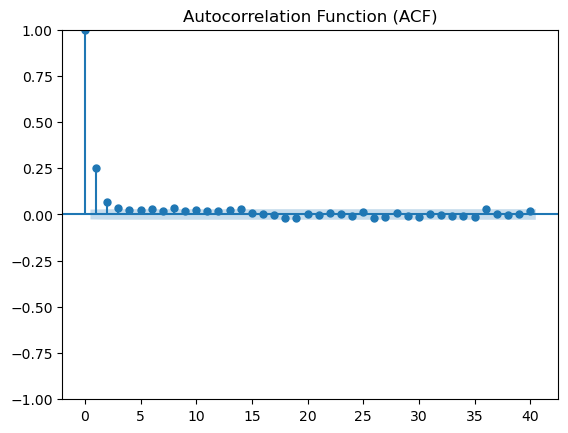

<Figure size 1000x500 with 0 Axes>

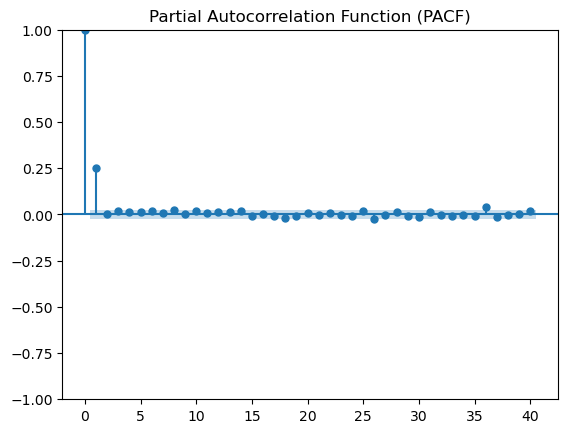

             Sim_1        Sim_2        Sim_3        Sim_4        Sim_5  \
count  5387.000000  5387.000000  5387.000000  5387.000000  5386.000000   
mean      1.122543     1.120879     1.179623     1.123463     1.122818   
std       2.526655     2.572789     3.359010     2.530256     2.863250   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.198161     0.195580     0.198497     0.198107     0.200447   
50%       0.398442     0.399003     0.401473     0.396529     0.400147   
75%       0.974159     0.985295     0.989776     0.986012     0.973515   
max      35.554449    55.400435    91.504728    42.633200    84.206894   

             Sim_6        Sim_7        Sim_8        Sim_9       Sim_10  
count  5386.000000  5387.000000  5387.000000  5387.000000  5387.000000  
mean      1.137212     1.117467     1.111799     1.119587     1.142121  
std       2.790922     2.525037     2.481346     2.609060     3.057761  
min       0.000000     0.000000     0.000

In [20]:
# Display ACF and PACF plots of the original data
mar_generator.display_acf_plot()
mar_generator.display_pacf_plot()

# Print summary statistics of the generated trajectories
print(generated_trajectories.describe())